We will use different deep learning models and data visualization to find the most accurate model for predicting stock market prices.

If you need to download the dataset to mount it to your drive the link is here: https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset

In [53]:
# Importing the libraries
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, SimpleRNN
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

In [2]:
# Function to help out with graphing, only relate to the plots
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

# Function to calculate the root mean squared error which tells us how accurate the model is. The lower the rsme the better.
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# Retrieve dataset from mounted google drive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/NASDAQ_Dataset/FinalProjectData/stocks')

# Read the csv into a dataset variable sorted by their dates. This is for a single csv for a single stock. For this example we used IBM
# from our NASDAQ data set. We are not using our entire 8000 file dataset yet.
dataset = pd.read_csv('../stocks/IBM.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

Mounted at /content/gdrive


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,0.618153,387200
1962-01-03,7.626667,7.693333,7.626667,7.693333,0.623556,288000
1962-01-04,7.693333,7.693333,7.613333,7.616667,0.617343,256000
1962-01-05,7.606667,7.606667,7.453333,7.466667,0.605185,363200
1962-01-08,7.460000,7.460000,7.266667,7.326667,0.593837,544000


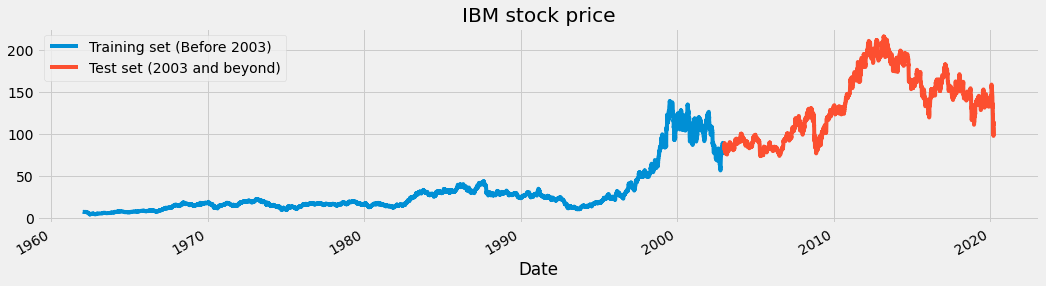

In [4]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2002'].plot(figsize=(16,4),legend=True)
dataset["High"]['2003':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2003)','Test set (2003 and beyond)'])
plt.title('IBM stock price')
plt.show()

Our NASDAQ CSV files have data from 1962 to 2020, however as most of the data before 1995 is largely flat compared to modern trends we can ignore this section to make more accurate predictions. We split this train and test data as a 70/30 split with the training data being from 1995 to 2012 and the testing data being from 2013 and beyond.

In [5]:
# Checking for missing values
training_set = dataset['1995':'2012'].iloc[:,1:2].values
test_set = dataset['2013':].iloc[:,1:2].values

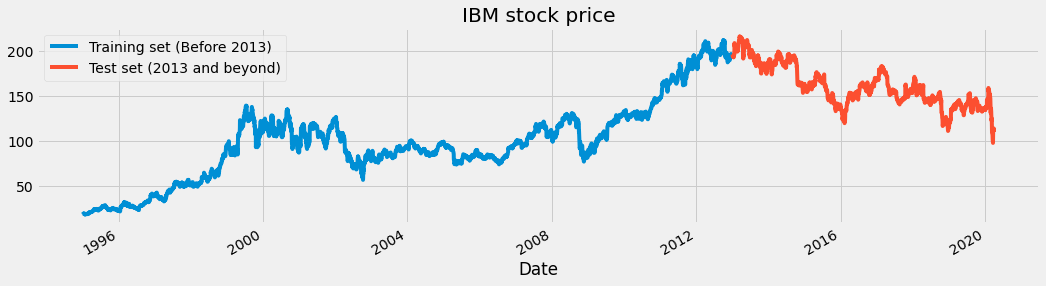

In [6]:
# Graph of the altered dataset
dataset["High"]['1995':'2012'].plot(figsize=(16,4),legend=True)
dataset["High"]['2013':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2013)','Test set (2013 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 13s 17ms/step - loss: 0.0093
Epoch 2/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0038
Epoch 3/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 4/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0025
Epoch 5/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 6/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 7/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0017
Epoch 8/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0016
Epoch 9/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0014
Epoch 10/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0013
Epoch 11/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0013
Epoch 12/50
85/85 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 13/50
85/85 [=================

In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"]['1995':'2012'],dataset["High"]['2013':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

Range changed to be 60 to 1885 to cover entire graph. This stops the rsme value from creating errors as well.

In [12]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

58/58 [==============================] - 2s 7ms/step


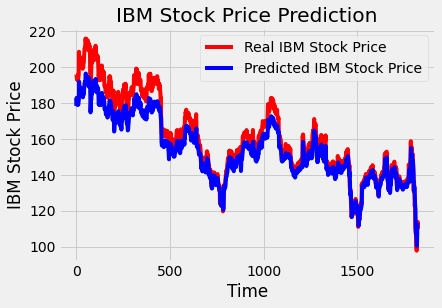

In [14]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [15]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.955618326521789.


The LSTM model produces the 2nd best rsme value.

GRU model gets us even better results

In [16]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 6s 21ms/step - loss: 0.0422
Epoch 2/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0148
Epoch 3/50
19/19 [==============================] - 0s 15ms/step - loss: 0.0067
Epoch 4/50
19/19 [==============================] - 0s 15ms/step - loss: 0.0030
Epoch 5/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0019
Epoch 6/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 7/50
19/19 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 8/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 9/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 11/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 12/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 13/50
19/19 [=============================

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [17]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

58/58 [==============================] - 2s 7ms/step


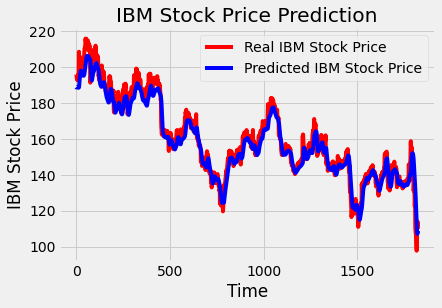

In [18]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [19]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.04019091949375.


The GRU model produces the lowest rsme value meaning it has the best accuracy. 

Now we will try the same data with different models. First BiLSTM.

In [65]:
# Output directory name
output_dir = 'model_output/biLSTM'

# Training
epochs = 6
batch_size = 128

# LSTM layer architecture
n_lstm = 256
drop_lstm = 0.2

# The BiLSTM architecture
regressor_bilstm = Sequential()
# First BiLSTM layer with Dropout regularisation
regressor_bilstm.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressor_bilstm.add(Dropout(0.2))
# LSTM layer
regressor_bilstm.add(LSTM(units=50, return_sequences=True))
regressor_bilstm.add(Dropout(0.2))
# LSTM layer
regressor_bilstm.add(LSTM(units=50, return_sequences=True))
regressor_bilstm.add(Dropout(0.2))
# LSTM layer
regressor_bilstm.add(LSTM(units=50))
regressor_bilstm.add(Dropout(0.2))
# The output layer
regressor_bilstm.add(Dense(1, activation='sigmoid'))

# Compiling the RNN
regressor_bilstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_bilstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 10s 22ms/step - loss: 0.0083
Epoch 2/50
85/85 [==============================] - 2s 21ms/step - loss: 0.0021
Epoch 3/50
85/85 [==============================] - 2s 20ms/step - loss: 0.0015
Epoch 4/50
85/85 [==============================] - 2s 19ms/step - loss: 0.0012
Epoch 5/50
85/85 [==============================] - 2s 19ms/step - loss: 9.8141e-04
Epoch 6/50
85/85 [==============================] - 2s 19ms/step - loss: 9.5116e-04
Epoch 7/50
85/85 [==============================] - 2s 20ms/step - loss: 8.1786e-04
Epoch 8/50
85/85 [==============================] - 2s 20ms/step - loss: 7.7268e-04
Epoch 9/50
85/85 [==============================] - 2s 28ms/step - loss: 6.8715e-04
Epoch 10/50
85/85 [==============================] - 2s 21ms/step - loss: 6.2833e-04
Epoch 11/50
85/85 [==============================] - 2s 26ms/step - loss: 6.2947e-04
Epoch 12/50
85/85 [==============================] - 2s 23ms/step - loss: 5.7966e-04
Epoc

In [21]:
regressor_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 60, 100)          20800     
 l)                                                              
                                                                 
 dropout_8 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            30200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                      

In [22]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
Bilstm_predicted_stock_price = regressor_bilstm.predict(X_test)
Bilstm_predicted_stock_price = sc.inverse_transform(Bilstm_predicted_stock_price)

#Y_test = []
#for i in range(60,1885):
#    Y_test.append(inputs[i-60:i,0])
#Y_test = np.array(Y_test)
#Y_test = np.reshape(Y_test, (Y_test.shape[0],Y_test.shape[1],1))
#Bilstm_predicted_stock_price = regressor_bilstm.predict(Y_test)
#Bilstm_predicted_stock_price = sc.inverse_transform(Bilstm_predicted_stock_price)


58/58 [==============================] - 2s 9ms/step


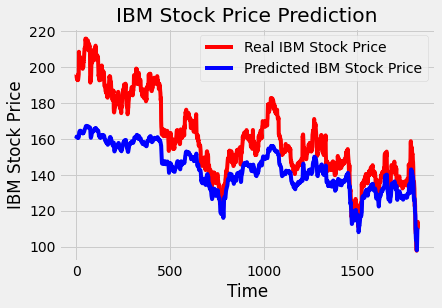

In [24]:
# Visualizing the results for BiLSTM
plot_predictions(test_set,Bilstm_predicted_stock_price)

In [25]:
# Evaluating Bilstm
return_rmse(test_set,Bilstm_predicted_stock_price)

The root mean squared error is 19.954482641266626.


The Bidirectional LSTM produces a much higher rsme value. 

The next model we'll test is Stacked BiLSTM

In [66]:
# The Stacked BiLSTM architecture
regressor_SBiLSTM = Sequential()
# First BiLSTM layer with Dropout regularisation
regressor_SBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressor_SBiLSTM.add(Dropout(0.2))
# Second BiLSTM layer
regressor_SBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_SBiLSTM.add(Dropout(0.2))
# Third BiLSTM layer
regressor_SBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_SBiLSTM.add(Dropout(0.2))
# LSTM layer
regressor_SBiLSTM.add(LSTM(units=50))
regressor_SBiLSTM.add(Dropout(0.2))
# The output layer
regressor_SBiLSTM.add(Dense(1, activation='sigmoid'))

# Compiling the RNN
regressor_SBiLSTM.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_SBiLSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 16s 31ms/step - loss: 0.0096
Epoch 2/50
85/85 [==============================] - 3s 34ms/step - loss: 0.0021
Epoch 3/50
85/85 [==============================] - 3s 39ms/step - loss: 0.0014
Epoch 4/50
85/85 [==============================] - 3s 39ms/step - loss: 0.0011
Epoch 5/50
85/85 [==============================] - 3s 31ms/step - loss: 9.0826e-04
Epoch 6/50
85/85 [==============================] - 3s 37ms/step - loss: 8.4621e-04
Epoch 7/50
85/85 [==============================] - 3s 35ms/step - loss: 6.8730e-04
Epoch 8/50
85/85 [==============================] - 3s 40ms/step - loss: 6.7329e-04
Epoch 9/50
85/85 [==============================] - 3s 39ms/step - loss: 6.0261e-04
Epoch 10/50
85/85 [==============================] - 3s 35ms/step - loss: 5.9996e-04
Epoch 11/50
85/85 [==============================] - 3s 36ms/step - loss: 5.4021e-04
Epoch 12/50
85/85 [==============================] - 3s 30ms/step - loss: 5.1071e-04
Epoc

In [29]:
regressor_SBiLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 60, 100)          20800     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 100)          60400     
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            30200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)           

In [30]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
SBiLSTM_predicted_stock_price = regressor_SBiLSTM.predict(X_test)
SBiLSTM_predicted_stock_price = sc.inverse_transform(SBiLSTM_predicted_stock_price)

58/58 [==============================] - 3s 11ms/step


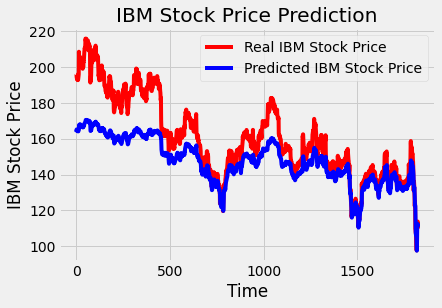

In [31]:
# Visualizing the results for Stacked BiLSTM
plot_predictions(test_set,SBiLSTM_predicted_stock_price)

In [67]:
# Evaluating Stacked Bilstm
return_rmse(test_set,SBiLSTM_predicted_stock_price)

The root mean squared error is 16.55332045933408.


This mode still produced a high rsme value but is an improvement over the previous model.

For the next model we'll try a CNN Stack BiLSTM model. 

In [68]:
# Dense layer architecture
n_dense = 64
drop = 0.5


# The Stacked BiLSTM architecture
regressor_dlstm = Sequential()
# First BiLSTM layer with Dropout regularisation
regressor_dlstm.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressor_dlstm.add(Dropout(0.2))
# Second BiLSTM layer
regressor_dlstm.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_dlstm.add(Dropout(0.2))
# Third BiLSTM layer
regressor_dlstm.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
# Dense layer
regressor_dlstm.add(Dense(n_dense, activation='relu'))
regressor_dlstm.add(Dropout(drop))
# The output layer
regressor_dlstm.add(Dense(1, activation='sigmoid'))

# Compiling the RNN
regressor_dlstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_dlstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 15s 31ms/step - loss: 0.0103
Epoch 2/50
85/85 [==============================] - 2s 28ms/step - loss: 0.0023
Epoch 3/50
85/85 [==============================] - 2s 27ms/step - loss: 0.0018
Epoch 4/50
85/85 [==============================] - 2s 29ms/step - loss: 0.0015
Epoch 5/50
85/85 [==============================] - 3s 30ms/step - loss: 0.0013
Epoch 6/50
85/85 [==============================] - 3s 41ms/step - loss: 0.0011
Epoch 7/50
85/85 [==============================] - 3s 33ms/step - loss: 0.0010
Epoch 8/50
85/85 [==============================] - 3s 36ms/step - loss: 9.9087e-04
Epoch 9/50
85/85 [==============================] - 4s 44ms/step - loss: 9.0633e-04
Epoch 10/50
85/85 [==============================] - 4s 41ms/step - loss: 9.2859e-04
Epoch 11/50
85/85 [==============================] - 4s 42ms/step - loss: 8.2781e-04
Epoch 12/50
85/85 [==============================] - 3s 33ms/step - loss: 8.1572e-04
Epoch 13/50
85/8

In [60]:
regressor_dlstm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_27 (Bidirecti  (None, 60, 100)          20800     
 onal)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 60, 100)          60400     
 onal)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                     

In [61]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
dlstm_predicted_stock_price = regressor_dlstm.predict(X_test)
dlstm_predicted_stock_price = sc.inverse_transform(dlstm_predicted_stock_price)

58/58 [==============================] - 4s 12ms/step


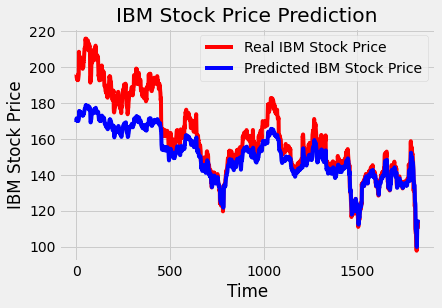

In [62]:
# Visualizing the results for Stacked BiLSTM
plot_predictions(test_set,dlstm_predicted_stock_price)

In [63]:
# Evaluating Bilstm
return_rmse(test_set,dlstm_predicted_stock_price)

The root mean squared error is 12.88663791674849.


This Stacked BiLSTM model with an added dense layer had an even bigger improvement than the previous model. 

For this model we added an rnn layer which is regularly recognized as a poor choice for stock market datasets.

In [69]:
# RNN layer architecture
n_rnn = 256
drop_rnn = 0.2

# Dense layer architecture
n_dense = 64
drop = 0.5


# The Stacked BiLSTM architecture
regressor_rnnlstm = Sequential()
# First BiLSTM layer with Dropout regularisation
regressor_rnnlstm.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressor_rnnlstm.add(Dropout(0.2))
# Second BiLSTM layer
regressor_rnnlstm.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_rnnlstm.add(Dropout(0.2))
# Third BiLSTM layer, commented out to meet dimension requirements
#regressor_rnnlstm.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
# RNN layer
regressor_rnnlstm.add(SimpleRNN(n_rnn, dropout=drop_rnn))
# The output layer
regressor_rnnlstm.add(Dense(1, activation='sigmoid'))

# Compiling the RNN
regressor_rnnlstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_rnnlstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 17s 119ms/step - loss: 0.0542
Epoch 2/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0122
Epoch 3/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0064
Epoch 4/50
85/85 [==============================] - 10s 114ms/step - loss: 0.0036
Epoch 5/50
85/85 [==============================] - 8s 98ms/step - loss: 0.0026
Epoch 6/50
85/85 [==============================] - 13s 148ms/step - loss: 0.0020
Epoch 7/50
85/85 [==============================] - 12s 137ms/step - loss: 0.0019
Epoch 8/50
85/85 [==============================] - 9s 112ms/step - loss: 0.0016
Epoch 9/50
85/85 [==============================] - 11s 127ms/step - loss: 0.0016
Epoch 10/50
85/85 [==============================] - 12s 145ms/step - loss: 0.0015
Epoch 11/50
85/85 [==============================] - 13s 149ms/step - loss: 0.0015
Epoch 12/50
85/85 [==============================] - 13s 155ms/step - loss: 0.0014
Epoch 13/50
85/8

In [48]:
regressor_rnnlstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirecti  (None, 60, 100)          20800     
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 60, 100)          60400     
 onal)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 60, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               91392     
                                                                 
 dense_9 (Dense)             (None, 1)               

In [49]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
rnnlstm_predicted_stock_price = regressor_rnnlstm.predict(X_test)
rnnlstm_predicted_stock_price = sc.inverse_transform(rnnlstm_predicted_stock_price)

58/58 [==============================] - 2s 13ms/step


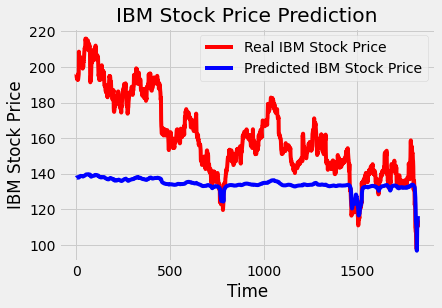

In [50]:
# Visualizing the results for Stacked BiLSTM
plot_predictions(test_set,rnnlstm_predicted_stock_price)

In [51]:
# Evaluating Bilstm
return_rmse(test_set,rnnlstm_predicted_stock_price)

The root mean squared error is 32.881519786289736.


Adding an RNN layer easily produced the worst results so far with a nearly flat line not even close to matching the actual graph. This produces the worst rsme value of all the models. 

In [54]:
# Convolutional layer architecture
n_conv = 256
k_conv = 3


# The Stacked BiLSTM architecture
regressor_cnnlstm = Sequential()
# First BiLSTM layer with Dropout regularisation
regressor_cnnlstm.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressor_cnnlstm.add(Dropout(0.2))
# Second BiLSTM layer
regressor_cnnlstm.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_cnnlstm.add(Dropout(0.2))
# Convolutional layer
regressor_cnnlstm.add(Conv1D(n_conv, k_conv, activation='relu'))
regressor_cnnlstm.add(GlobalMaxPooling1D())
# Dense layer
regressor_cnnlstm.add(Dense(n_dense, activation='relu'))
regressor_cnnlstm.add(Dropout(drop))
# The output layer
regressor_cnnlstm.add(Dense(1, activation='sigmoid'))

# Compiling the RNN
regressor_cnnlstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_cnnlstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 13s 19ms/step - loss: 0.0082
Epoch 2/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0028
Epoch 3/50
85/85 [==============================] - 1s 18ms/step - loss: 0.0023
Epoch 4/50
85/85 [==============================] - 1s 18ms/step - loss: 0.0019
Epoch 5/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 6/50
85/85 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 7/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0016
Epoch 8/50
85/85 [==============================] - 1s 18ms/step - loss: 0.0014
Epoch 9/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0013
Epoch 10/50
85/85 [==============================] - 2s 18ms/step - loss: 0.0013
Epoch 11/50
85/85 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 12/50
85/85 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 13/50
85/85 [=================

In [55]:
regressor_cnnlstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_25 (Bidirecti  (None, 60, 100)          20800     
 onal)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_26 (Bidirecti  (None, 60, 100)          60400     
 onal)                                                           
                                                                 
 dropout_34 (Dropout)        (None, 60, 100)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 58, 256)           77056     
                                                                 
 global_max_pooling1d (Globa  (None, 256)            

In [56]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1885):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
cnnlstm_predicted_stock_price = regressor_cnnlstm.predict(X_test)
cnnlstm_predicted_stock_price = sc.inverse_transform(cnnlstm_predicted_stock_price)

58/58 [==============================] - 2s 9ms/step


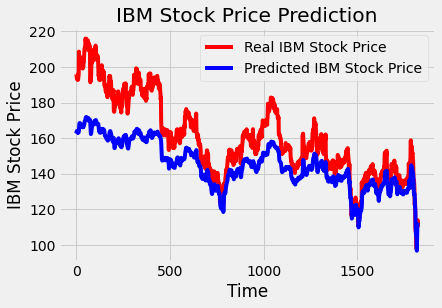

In [57]:
# Visualizing the results for Stacked BiLSTM
plot_predictions(test_set,cnnlstm_predicted_stock_price)

In [58]:
# Evaluating Bilstm
return_rmse(test_set,cnnlstm_predicted_stock_price)

The root mean squared error is 18.182035141608065.


This Convolutional Stacked BiLSTM produces pretty poor results compared to the other models. It gets the 3rd worst rsme value. 

Lastly, we'll attempt to visualize the models. This visualization covers the BiLSTM model. Trying to apply the visualization techniques from our lectures proved to be difficult as our dataset's shape/dimensions tends to produce errors. Fixing these visualizations would be a simple way to expand upon our work. 

In [70]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [71]:
history = regressor_bilstm.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1,validation_data=(X_test, Y_test),callbacks=[modelcheckpoint])

NameError: ignored

In [ ]:
loss_train = history.history('loss')
loss_val = history.history('val_loss')
epochs = range(1,51)
plt.plot(epochs, loss_train, 'b', label='training')
plt.plot(epochs, val_loss, 'g', label='validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history('accuracy')
loss_val = history.history('val_accuracy')
epochs = range(1,51)
plt.plot(epochs, loss_train, 'b', label='training')
plt.plot(epochs, val_loss, 'g', label='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
regressor_bilstm.load_weights(output_dir+"/weights.{epoch:02d}.hdf5")

In [ ]:
y_hat = regressor_bilstm.predict(X_test)

In [ ]:
plt.hist(y_hat)
_ = plt.axv_line(x=0.5, color='orange')

In [ ]:
"{:0.2f}".format(roc_auc_score(X_test, y_hat)*100.0)

In [ ]:
fpr, tpr, thresholds = roc_curve(X_test, y_hat)
plt.plot(fpr, tpr)
plt.axis[0,1,0,1]
plt.title('False Positive Rate vs True Positive Rate ROC-AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Overall GRU ended up being our most accurate model. These tests should work with any of the csv files in our dataset but we chose the IBM csv to match the related works for comparison. Another potential point of exploration for this project could be to change from the "High" column of the stock prices to "Adjusted Closing Price" or "Low" to see how the model is affected or decide which category of stock data is more relevant for making regular predictions.